# Dataset de Exemplo

In [ ]:
!gdown --id 131G4xQHMnxxEW6jGVW5aBR7z3Hps8HlW

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=131G4xQHMnxxEW6jGVW5aBR7z3Hps8HlW
To: /content/google_photos_en_us_2.4mi.pkl
100% 670M/670M [00:06<00:00, 105MB/s] 


In [ ]:
import pandas as pd

df = pd.read_pickle('google_photos_en_us_2.4mi.pkl')[['content','score']]
df = df[(df.score  == 1) | (df.score  == 5)].dropna()
df = df[df.content.str.len() > 100]
df

,content,score
36,Great place to store and view your photos Edit...,1
73,All nonsense Google app. Photos uploaded autom...,1
89,Didn't ask for it ... I'm fine with just a sim...,1
110,"Good App By Google, Because It's Works Really ...",5
137,Have been using G Photos for awhile and I pref...,5
...,...,...
2398915,this is the best app for photos for google rec...,5
2399036,why theres no option for select all.. just hav...,5
2399061,No better Photo app that exsists witht the fre...,5
2399080,awesome it creates things on its own that are ...,5


In [ ]:
df['score'].value_counts(normalize=True)

5    0.676072
1    0.323928
Name: score, dtype: float64

# Extraindo Conceitos do Dataset para Construção da Rede Heterogênea

### Parte 1 - Gerando Candidatos (ngramas)

In [ ]:
import nltk
from tqdm.notebook import tqdm
from nltk.util import ngrams
import nltk.data
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

nltk.download('punkt')
nltk.download('stopwords')
sentence_tokenizer = nltk.data.load('tokenizers/punkt/PY3/english.pickle')

stop_words = nltk.corpus.stopwords.words('english')+'please;new;use;lot;many;alone;getting;longer;way;see;give;soon;ass;fact;would;sucks;without;could;negative;thank;you;so;much'.split(';')


total = 0
categories=['all']
for category in categories:
  print(category)
  !rm {category}'_ngrams.txt'
  with open(str(category)+'_ngrams.txt', 'a') as the_file:

    df_temp = df
    for index,row in tqdm(df_temp.iterrows(),total=len(df_temp)):

      sentences = sentence_tokenizer.tokenize(row['content'])
      for sentence in sentences:
        #tokenize = nltk.word_tokenize(sentence)
        tokenize = tknzr.tokenize(sentence)

        for n in range(4,11):
          try:
            ngram = ngrams(tokenize,n)
            for item in ngram:
              if item[0].lower() in stop_words: continue
              if item[n-1].lower() in stop_words: continue
              if item[n-1].lower() == item[0].lower(): continue
              if len(item[0]) <= 2: continue
              if len(item[n-1]) <= 2: continue
              for w in item: the_file.write(w.lower()+' ')
              the_file.write("\n")
          except:
            1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


all


  0%|          | 0/67938 [00:00<?, ?it/s]

In [ ]:
!sort all_ngrams.txt | uniq -c | sort -nr > all_ngrams_freq.txt

tcmalloc: large alloc 6206193664 bytes == 0x5566612a2000 @  0x7fbbebc351e7 0x55665f563718 0x55665f5625a1 0x7fbbeb613c87 0x55665f56302a


In [ ]:
L = []

def generate_ngrams(category,filepath,L,min_freq=2):

  with open(filepath) as fp:
    line = fp.readline()
    while line:

        v = line.strip().split(' ')
        freq = int(v[0])
        if freq >= min_freq and ',' not in line and '.' not in line and ';' not in line and ':' not in line:
          ngram = line.strip().replace(v[0],'')
          L.append( [category,freq,ngram]  )
        line = fp.readline()



In [ ]:
category='all'
generate_ngrams(category,category+'_ngrams_freq.txt',L)

In [ ]:
df_ngrams = pd.DataFrame(L)
df_ngrams.columns = ['category','freq','ngram']
df_ngrams

,category,freq,ngram
0,all,337,one of the best
1,all,250,space on my phone
2,all,198,keep up the good
3,all,189,keep up the good work
4,all,184,thanks to google photos
...,...,...,...
33869,all,2,ጀምሮ መውጫ መግቢያ እያጣን ስለሆነ
33870,all,2,ጀምሮ መውጫ መግቢያ እያጣን
33871,all,2,ᕗᕦᶘ ᵒ ㉨ ᵒᶅᕤ
33872,all,2,ᕤᕦʕ • ᴥ • ʔᕤᕙ


In [ ]:
df_ngrams[df_ngrams.ngram.str.contains('pay')]

,category,freq,ngram
174,all,29,pay for more storage
496,all,16,pay for extra storage
1271,all,9,want us to pay
1817,all,7,want me to pay
1978,all,7,pay for unlimited storage
...,...,...,...
32955,all,2,also you're holding something irrelevant for ...
33333,all,2,afford to pay for photos and videos storage
33334,all,2,afford to pay for photos and videos
33335,all,2,afford to pay for photos


## Parte 2 - Selecionando Conceitos (nodes)
Nesse exemplo, nossos conceitos são ngramas bem formados (sem finalizar com stopwords) e que possuem alguma palavra de opinião

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
L = []
for index,row in tqdm(df_ngrams.iterrows(),total=len(df_ngrams)):
    ngram = row['ngram']
    vs = analyzer.polarity_scores(ngram)
    if vs['compound'] >= 0.1 or vs['compound'] <= -0.1:
    #print(ngram,vs['compound'])
      L.append([row['category'],ngram,row['freq'],vs['compound']])


  0%|          | 0/33874 [00:00<?, ?it/s]

In [ ]:
df_selected = pd.DataFrame(L)
df_selected.columns=['category','concept','freq','score']
df_selected = df_selected[df_selected.freq >= 5]
df_selected

,category,concept,freq,score
0,all,one of the best,337,0.6369
1,all,keep up the good,198,0.4404
2,all,keep up the good work,189,0.4404
3,all,thanks to google photos,184,0.4404
4,all,photos is the best,154,0.6369
...,...,...,...,...
1653,all,able to create albums,5,0.2732
1654,all,ability to share albums,5,0.5423
1655,all,2021 are exempt from this change and will not...,5,0.1027
1656,all,1gb of free storage,5,0.5106


In [ ]:
df_selected[df_selected['score']<=0]

,category,concept,freq,score
8,all,lost all my photos,139,-0.3182
12,all,thought i had lost,118,-0.3182
24,all,lost all my pictures,65,-0.3182
61,all,even if i lose,34,-0.4019
66,all,one of the worst,32,-0.6249
...,...,...,...,...
1609,all,avoid at all costs,5,-0.2960
1623,all,app is no good,5,-0.3412
1643,all,accidentally deleted a photo,5,-0.3400
1644,all,accidentally delete a picture,5,-0.3400


Exemplos de features extraídas.

In [ ]:
df_selected[df_selected.concept.str.contains('lost')]

,category,concept,freq,score
8,all,lost all my photos,139,-0.3182
12,all,thought i had lost,118,-0.3182
24,all,lost all my pictures,65,-0.3182
101,all,thought i lost all my photos,24,-0.3182
120,all,lost all my pics,22,-0.3182
...,...,...,...,...
1433,all,lost hundreds of photos,5,-0.3182
1434,all,lost everything on my phone,5,-0.3182
1435,all,lost a lot of my photos,5,-0.3182
1436,all,lost a few phones,5,-0.3182


In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

In [ ]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [ ]:
embeddings = model.encode(df_selected.concept.to_list(),show_progress_bar=True)

Batches:   0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
embeddings.shape

(1658, 768)

In [ ]:
df_selected['embedding'] = list(embeddings)

In [ ]:
df_selected = df_selected.reset_index(drop=True)

In [ ]:
df_selected

,category,concept,freq,score,embedding
0,all,one of the best,337,0.6369,"[-0.06776428, -0.13487168, -0.012511861, 0.100..."
1,all,keep up the good,198,0.4404,"[0.07893612, 0.16609594, -0.014071807, -0.0279..."
2,all,keep up the good work,189,0.4404,"[0.013165223, 0.16339824, -0.013693146, -0.045..."
3,all,thanks to google photos,184,0.4404,"[-0.08638844, 0.017038846, -0.00835953, 0.1510..."
4,all,photos is the best,154,0.6369,"[-0.1940136, -0.11014851, -0.010693614, 0.1343..."
...,...,...,...,...,...
1653,all,able to create albums,5,0.2732,"[-0.11643301, 0.18221845, -0.008490351, 0.0544..."
1654,all,ability to share albums,5,0.5423,"[-0.061100427, 0.11528311, -0.004971999, 0.099..."
1655,all,2021 are exempt from this change and will not...,5,0.1027,"[-0.06079127, 0.19225252, -0.010355515, 0.0999..."
1656,all,1gb of free storage,5,0.5106,"[0.0446765, -0.067407265, -0.0028233908, 0.102..."


# Classificador para Redes Heterogêneas

In [ ]:
import numpy as np
def lphn(G,num_labels,max_iter=5):

  # inicializando
  for n in G.nodes():
    G.nodes[n]['f'] = np.zeros(num_labels)
    if 'y' in G.nodes[n]:
      G.nodes[n]['f'] = G.nodes[n]['y']*1

  for i in range(0,max_iter):

    # propagando
    diff = 0
    for node in G.nodes():
      f_new = np.zeros(num_labels)
      count = 0
      for neighbor in G.neighbors(node):
        f_new += G.nodes[neighbor]['f']
        count += 1

      f_new /= count
      diff += np.linalg.norm(G.nodes[node]['f']-f_new)
      G.nodes[node]['f']=f_new

      if 'y' in G.nodes[node]:
        G.nodes[node]['f'] = G.nodes[node]['y']
    print("Iteration #"+str(i+1)+" Q(F)="+str(diff))

### Avaliando Cenário 1
Rede Bipartida = Doc <-> Concept

In [ ]:
from tqdm.notebook import tqdm
import networkx as nx

# gerando rede heterogênea doc <-> concept
G = nx.Graph()
dataset_final = []
# para cada concept
for index,row in tqdm(df_selected.iterrows(),total=len(df_selected)):
  # buscando documentos que contem o concept
  df_docs = df[df.content.str.contains(row['concept'])]
  for index2,row2 in df_docs.iterrows():
    dataset_final.append(row2)
    G.add_edge(str(index2)+':doc',row['concept']+':concept')

  0%|          | 0/1658 [00:00<?, ?it/s]

In [ ]:
df_dataset_final = pd.DataFrame(dataset_final).drop_duplicates()
df_dataset_final

,content,score
13084,Google photos is very nice app to have and my ...,5
17160,Lovely it is incredible this is one of the bes...,5
30965,Google photos has to be one of the best tools ...,5
59534,It was one of the best cloud apps until they b...,1
90169,"Great to have, perfect for the photographer. T...",5
...,...,...
796842,I love this app. I am able to create albums or...,5
1674535,I like this app very much. It is able to creat...,5
110794,My favorite feature is the ability to share al...,5
1002043,My fav part of this app is having the ability ...,5


In [ ]:
print('Nodes=',G.number_of_nodes(),' Edges=',G.number_of_edges())

Nodes= 10563  Edges= 12266


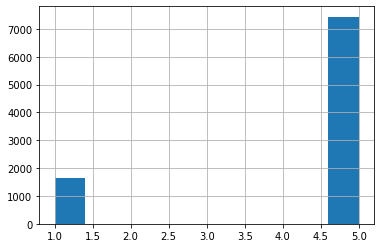

In [ ]:
df_dataset_final.score.hist()

# Dataset de Avali

# Calcular resultados experimentais
Repetir com diferentes random_state e apresentar resultados medios + desvio padrao

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline
def classifier_metrics(y_true,y_pred,cmap='Blues'):
  print(classification_report(y_true,y_pred))
  plt.figure(figsize=(5,5))
  sns.heatmap(confusion_matrix(y_true,y_pred),cmap=cmap,annot=True,fmt='g', cbar=False)
  plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

random_state=42

doc_nodes = []
for node in G.nodes():
  if ':doc' in node: doc_nodes.append(node)

# para avaliacao, explorar diferentes qtd de documentos inicialmente rotulados
pct_labeled = [0.01,0.02,0.05,0.1,0.2,0.3]

summary = []
for pct_labels in pct_labeled:

  nodes_train,nodes_test = train_test_split(doc_nodes, test_size=0.3, random_state=random_state)
  nodes_train,_ = train_test_split(nodes_train, test_size=1.0-pct_labels, random_state=random_state)

  # rotulando nodes na rede conforme df_train
  for node in G.nodes():
    if 'y' in G.nodes[node]: del G.nodes[node]['y'] # removendo anotacoes previas

  for node in nodes_train: # rotulando nodes na rede
    star_score = df[df.index==int(node.replace(':doc',''))].score.to_list()[0]
    if star_score == 1: G.nodes[node]['y'] = np.array([1.0, 0.0])
    if star_score == 5: G.nodes[node]['y'] = np.array([0.0, 1.0])

  lphn(G,2)

  y_pred = []
  y_true = []

  for node in tqdm(nodes_test):

    label_pred = np.argmax(G.nodes[node]['f']) # verifica a label mais provavel
    if label_pred == 0: y_pred.append(1) # 1 score
    if label_pred == 1: y_pred.append(5) # 5 score

    y_true.append(df[df.index==int(node.replace(':doc',''))].score.to_list()[0])

  print('======================================')
  print('Resultado com % nodes rotulados =',pct_labels)
  print('nodes_train =',len(nodes_train))
  print('nodes_test =',len(nodes_test))
  acc = accuracy_score(y_true, y_pred)
  print('acc=',acc)
  f1_score_macro =f1_score(y_true, y_pred, average='macro')
#  classifier_metrics(y_true,y_pred)
  summary.append(['Resultado (acc) com % nodes rotulados = '+str(pct_labels),acc,f1_score_macro])
  print('======================================')

Iteration #1 Q(F)=118.38263459645349
Iteration #2 Q(F)=113.95820831916107
Iteration #3 Q(F)=103.6179822757389
Iteration #4 Q(F)=95.63054810021254
Iteration #5 Q(F)=89.29875324410847


  0%|          | 0/2724 [00:00<?, ?it/s]

Resultado com % nodes rotulados = 0.01
nodes_train = 63
nodes_test = 2724
acc= 0.7257709251101322
Iteration #1 Q(F)=236.14817811565393
Iteration #2 Q(F)=225.95102016900117
Iteration #3 Q(F)=204.58101982870613
Iteration #4 Q(F)=188.47627359153304
Iteration #5 Q(F)=175.66743389333305


  0%|          | 0/2724 [00:00<?, ?it/s]

Resultado com % nodes rotulados = 0.02
nodes_train = 127
nodes_test = 2724
acc= 0.7158590308370044
Iteration #1 Q(F)=563.7246884309305
Iteration #2 Q(F)=527.0152247027289
Iteration #3 Q(F)=467.910786088745
Iteration #4 Q(F)=423.7198794417582
Iteration #5 Q(F)=388.45994407277783


  0%|          | 0/2724 [00:00<?, ?it/s]

Resultado com % nodes rotulados = 0.05
nodes_train = 317
nodes_test = 2724
acc= 0.7709251101321586
Iteration #1 Q(F)=1101.015373495054
Iteration #2 Q(F)=994.8105965984764
Iteration #3 Q(F)=859.9291146763744
Iteration #4 Q(F)=759.5844747966066
Iteration #5 Q(F)=680.329435405059


  0%|          | 0/2724 [00:00<?, ?it/s]

Resultado com % nodes rotulados = 0.1
nodes_train = 635
nodes_test = 2724
acc= 0.7973568281938326
Iteration #1 Q(F)=2061.472372712991
Iteration #2 Q(F)=1741.2777245160387
Iteration #3 Q(F)=1421.1708380455016
Iteration #4 Q(F)=1194.4961239271745
Iteration #5 Q(F)=1023.8003496926243


  0%|          | 0/2724 [00:00<?, ?it/s]

Resultado com % nodes rotulados = 0.2
nodes_train = 1270
nodes_test = 2724
acc= 0.8175477239353891
Iteration #1 Q(F)=2891.8139523096625
Iteration #2 Q(F)=2311.471239412279
Iteration #3 Q(F)=1794.2132988210988
Iteration #4 Q(F)=1443.3181957491583
Iteration #5 Q(F)=1190.9311563436333


  0%|          | 0/2724 [00:00<?, ?it/s]

Resultado com % nodes rotulados = 0.3
nodes_train = 1906
nodes_test = 2724
acc= 0.8461820851688693


In [ ]:
for s in summary:
  print(s)

['Resultado (acc) com % nodes rotulados = 0.01', 0.7257709251101322, 0.614601821619616]
['Resultado (acc) com % nodes rotulados = 0.02', 0.7158590308370044, 0.6106501794974072]
['Resultado (acc) com % nodes rotulados = 0.05', 0.7709251101321586, 0.6649467628803553]
['Resultado (acc) com % nodes rotulados = 0.1', 0.7973568281938326, 0.692636009743103]
['Resultado (acc) com % nodes rotulados = 0.2', 0.8175477239353891, 0.7107916407738182]
['Resultado (acc) com % nodes rotulados = 0.3', 0.8461820851688693, 0.7432010567546643]


### Modelo 2


In [ ]:
from tqdm.notebook import tqdm
import networkx as nx
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
# gerando rede heterogênea doc <-> concept
cos_metrica =0.6

def geracao_grafo(cos_metrica):
  G = nx.Graph()
  dataset_final = []
  # para cada concept
  for index,row in tqdm(df_selected.iterrows(),total=len(df_selected)):
    # buscando documentos que contem o concept
    df_docs = df[df.content.str.contains(row['concept'])]
    for index2,row2 in df_docs.iterrows():
      dataset_final.append(row2)
      G.add_edge(str(index2)+':doc',row['concept']+':concept')
      for index3,row3 in df_selected.iterrows():
          if index != index3:
            cos =util.cos_sim(df_selected['embedding'].iloc[index], df_selected['embedding'].iloc[index3])
            if cos >=cos_metrica:
              G.add_edge(row['concept']+':concept',row3['concept']+':concept')
#              print(cos_metrica)
  return G

In [ ]:
def modelo_2(G,pct_labels):
  random_state=42

  doc_nodes = []
  for node in G.nodes():
    if ':doc' in node: doc_nodes.append(node)

  # para avaliacao, explorar diferentes qtd de documentos inicialmente rotulados
#  pct_labeled = [0.01,0.02,0.05,0.1,0.2,0.3]
#  pct_labeled = [0.01,0.02,0.05,0.1,0.2,0.3]
  summary = []
#  for pct_labels in pct_labeled:

  nodes_train,nodes_test = train_test_split(doc_nodes, test_size=0.3, random_state=random_state)
  nodes_train,_ = train_test_split(nodes_train, test_size=1.0-pct_labels, random_state=random_state)

    # rotulando nodes na rede conforme df_train
  for node in G.nodes():
    if 'y' in G.nodes[node]: del G.nodes[node]['y'] # removendo anotacoes previas

    for node in nodes_train: # rotulando nodes na rede
      star_score = df[df.index==int(node.replace(':doc',''))].score.to_list()[0]
      if star_score == 1: G.nodes[node]['y'] = np.array([1.0, 0.0])
      if star_score == 5: G.nodes[node]['y'] = np.array([0.0, 1.0])

    lphn(G,2)

    y_pred = []
    y_true = []

    for node in tqdm(nodes_test):

      label_pred = np.argmax(G.nodes[node]['f']) # verifica a label mais provavel
      if label_pred == 0: y_pred.append(1) # 1 score
      if label_pred == 1: y_pred.append(5) # 5 score

      y_true.append(df[df.index==int(node.replace(':doc',''))].score.to_list()[0])

#    print('======================================')
#    print('Resultado com % nodes rotulados =',pct_labels)
#    print('nodes_train =',len(nodes_train))
#    print('nodes_test =',len(nodes_test))
#    print('nodes_train =',len(nodes_train))
#    print('nodes_test =',len(nodes_test))
    acc = accuracy_score(y_true, y_pred)
#    print('acc=',acc)
    nodes =G.number_of_nodes()
    edges= G.number_of_edges()
#    print('nodes =',nodes)
#    print('edges =',edges)
    f1_score_macro =f1_score(y_true, y_pred, average='macro')
  #  classifier_metrics(y_true,y_pred)
    summary.append(['Resultado (acc) com % nodes rotulados = '+str(pct_labels),cos,acc,f1_score_macro,nodes,edges])
    print('======================================')
    print('pct_labels=',pct_labels)
    return summary

In [ ]:
pct_labeled = [0.01,0.02,0.05,0.1,0.2,0.3]
cos = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
resultado =[]

for cos in cos:
 G =geracao_grafo(cos)
 print('cos',cos)
 for pct_labels in pct_labeled:
    print(pct_labels)
    summary = modelo_2(G,pct_labels)
    resultado.append(summary)
    print(summary)

  0%|          | 0/100 [00:00<?, ?it/s]

0.01
Iteration #1 Q(F)=29.99749029073354
Iteration #2 Q(F)=28.736675685790555
Iteration #3 Q(F)=28.441682210060215
Iteration #4 Q(F)=28.311825070463602
Iteration #5 Q(F)=28.224202640402208


  0%|          | 0/909 [00:00<?, ?it/s]

pct_labels= 0.01
[['Resultado (acc) com % nodes rotulados = 0.01', 0.1, 0.8998899889988999, 0.6091246308328411, 3128, 7891]]
0.02
Iteration #1 Q(F)=59.74162091483212
Iteration #2 Q(F)=57.11185883049146
Iteration #3 Q(F)=56.3238336560605
Iteration #4 Q(F)=55.8682259965246
Iteration #5 Q(F)=55.522247278855374


  0%|          | 0/909 [00:00<?, ?it/s]

pct_labels= 0.02
[['Resultado (acc) com % nodes rotulados = 0.02', 0.1, 0.8833883388338833, 0.4782651072124756, 3128, 7891]]


  0%|          | 0/100 [00:00<?, ?it/s]

0.01
Iteration #1 Q(F)=31.753220184951836
Iteration #2 Q(F)=30.197045216827174
Iteration #3 Q(F)=29.645650870584703
Iteration #4 Q(F)=29.354598448457917
Iteration #5 Q(F)=29.15599495540679


  0%|          | 0/909 [00:00<?, ?it/s]

pct_labels= 0.01
[['Resultado (acc) com % nodes rotulados = 0.01', 0.2, 0.8987898789878987, 0.6077338736913205, 3128, 6998]]
0.02
Iteration #1 Q(F)=63.08658288957282
Iteration #2 Q(F)=59.8571445687708
Iteration #3 Q(F)=58.53588517994957
Iteration #4 Q(F)=57.713230744357034
Iteration #5 Q(F)=57.103189577259435


  0%|          | 0/909 [00:00<?, ?it/s]

pct_labels= 0.02
[['Resultado (acc) com % nodes rotulados = 0.02', 0.2, 0.8976897689768977, 0.6120038002395803, 3128, 6998]]
